## Capstone Project 2
Below we have the arrest rates for all states in the US. We will try to draw conclusions based upon principle component analysis and cluster techniques. A deep dive into the data is required to truly understand crimes and the reasoning. That's what we will be doing below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from pylab import rcParams

%matplotlib inline

arrests = pd.read_csv('UsArrests.csv')
arrests.head()


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


Firstly the "City" column is mislabelled it should be states. In fact there are 52 states in the US, not 50 as shown below.

In [2]:
arrests = arrests.rename(columns={'City': 'State'})
arrests.head()


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [3]:
arrests.shape

(50, 5)

No missing values within the dataset so we can move to the last few steps of pre processing the data.

In [4]:
missing_values_count = arrests.isnull().sum()
missing_values_count


State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [5]:
arrests.columns

Index(['State', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

We scale the data so we can get a more accurate reading later on.

In [6]:
scaler = StandardScaler()

arrests[['Murder', 'Assault', 'UrbanPop', 'Rape'
         ]] = scaler.fit_transform(arrests[['Murder', 'Assault', 'UrbanPop', 'Rape']])

arrests.head()


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,1.255179,0.790787,-0.526195,-0.003451
1,Alaska,0.513019,1.118060,-1.224067,2.509424
2,Arizona,0.072361,1.493817,1.009122,1.053466
3,Arkansas,0.234708,0.233212,-1.084492,-0.186794
4,California,0.281093,1.275635,1.776781,2.088814


Then we index the state.

In [7]:
arrests_df = arrests.set_index('State')
arrests_df.head()


,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


Below a heatmap is plotted to give you a general view of the overall data. Murder seemingly has a correlation to urban populations but how do we know for sure? Also are the stronger correlations? That's where PCA comes in. To further dive into our data only 2 variables need to be chosen. By doing this we reduce the dimensionality of our data and have a more accurate representation of what should be considered moving forward.

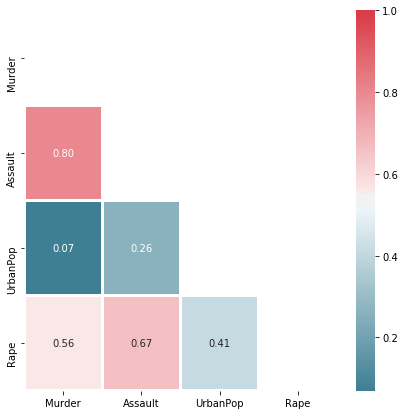

In [8]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)


def corr_heatmap(iris):
    # get correlations
    corrs = iris.corr()

    # Plot figsize
    fig, ax = plt.subplots(figsize=(7, 7))

    dropSelf = np.zeros_like(corrs)
    dropSelf[np.triu_indices_from(dropSelf)] = True

    ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f",
                     mask=dropSelf, linewidth=2)

    plt.show()

corr_heatmap(arrests_df)


Below we will choose 2 principle components and compare them to our values. This will give us a clear indication of what data columns should be taken and used for our benefit.

In [9]:
X = arrests_df[['Murder', 'Assault', 'UrbanPop', 'Rape']]
print(X.shape)


(50, 4)


In [10]:
nr_comps = 2
pca = PCA(n_components=nr_comps)

principal_components = pca.fit_transform(X)

pca_df = pd.DataFrame(principal_components, index=arrests_df.index)

pca_df.head()


,0,1
State,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


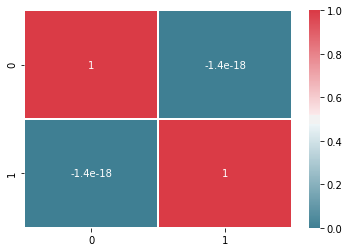

In [11]:
ax = sns.heatmap(pca_df.corr(), cmap=colormap, linewidth=1, annot=True)
plt.show()


Below we see that murder and urban population have the most adverse effects both tipping the scales in opposite ways. Whether positive or negative. It's all relative we now know for certain which columns matter.

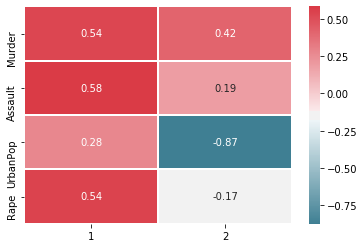

In [12]:
components = pd.DataFrame(pca.components_, columns=arrests_df.columns,
                          index=range(1, nr_comps+1)).transpose()
ax = sns.heatmap(components, cmap=colormap, linewidth=1, annot=True)
plt.show()


First we will be plotting a kmeans cluster but in order to do so we need to know which amount of clustering will be best suited. That's why a silhouette score line graph will be plotted to measure and tell us.

In [13]:
X = arrests[['Murder', 'UrbanPop']].values.reshape(-1, 2)

print(f'Data size: {X.shape}')

Data size: (50, 2)


In [14]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range
                (1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

silhouette_scores


[0.3375439719778302,
 0.37804676102179363,
 0.38572555545979403,
 0.3760751360692719,
 0.3678979694233131,
 0.35596868789492736,
 0.3715408549828094,
 0.38400133321276075]

Below we have a graph informing us of the optimal amount of clusters. This is important due to the fact that unsupervised machine learning algorithms perform better when they are given the right outputs. We could let the algorithm itself do all the work but that would take more time and hyperparameter tuning, which we are trying to avoid.

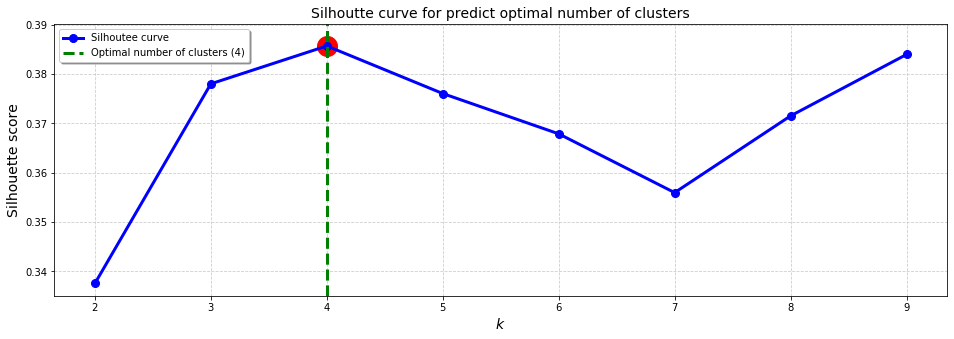

In [15]:
# Plot the silhoutee scores graph
rcParams['figure.figsize'] = 16, 5
_ = plt.plot(range(2, 10), silhouette_scores, "bo-", color='blue',
             linewidth=3, markersize=8, label='Silhoutee curve')
_ = plt.xlabel("$k$", fontsize=14)
_ = plt.ylabel("Silhouette score", fontsize=14)
_ = plt.grid(which='major', color='#cccccc', linestyle='--')

_ = plt.title('Silhoutte curve for predict optimal number of clusters',
              fontsize=14)

# Calculate the optimal number of cluster
k = np.argmax(silhouette_scores) + 2

# Draw a vertical line to mark optimal number of clusters
_ = plt.axvline(x=k, linestyle='--', C='green', linewidth=3,
                label='Optimal number of clusters ({})'.format(k))

_ = plt.scatter(k, silhouette_scores[k-2], c='red', s=400)
_ = plt.legend(shadow=True)

_ = plt.show()


Below we have the values and now have a "K" value that we can use moving forward.

In [16]:
max_sil = round(max(silhouette_scores), 2)
print(f'The optimal number of clusters for the given dataset is {k}.')
print(f'The silhouette score is {max_sil}.')
K = 4


The optimal number of clusters for the given dataset is 4.
The silhouette score is 0.39.


The model is starting to come together but there are other hyperparameters which still remain a mystery. A full report cannot be done until.

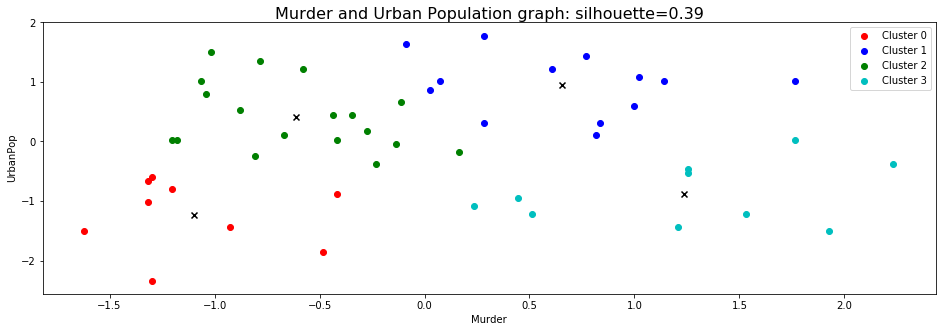

In [17]:
def scatter_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
        plt.scatter(x[y_pred == c, 0], x[y_pred == c, 1], c=colours[c],
                    label='Cluster {}'.format(c))
        plt.scatter(kmeans.cluster_centers_[c, 0],
                    kmeans.cluster_centers_[c, 1], marker='x', c='black')

    plt.title(f'Murder and Urban Population graph: silhouette={max_sil}',
              loc='center', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Murder')
    plt.ylabel('UrbanPop')
    plt.legend()
    plt.show()

scatter_Kmeans(X, k, r=0)


Below we determine which linkage type would be best suited for future use.

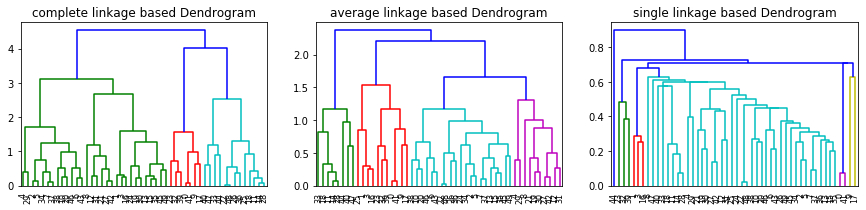

In [18]:
plt.figure(figsize=[15, 3])

linkage_types = ['complete', 'average', 'single']

for i, l in enumerate(linkage_types):
    plt.subplot(1, 3, i+1)
    dend = dendrogram(linkage(X, method=l))
    plt.title(f'{l} linkage based Dendrogram')

L = 'average'


Below we determine the best distance value.

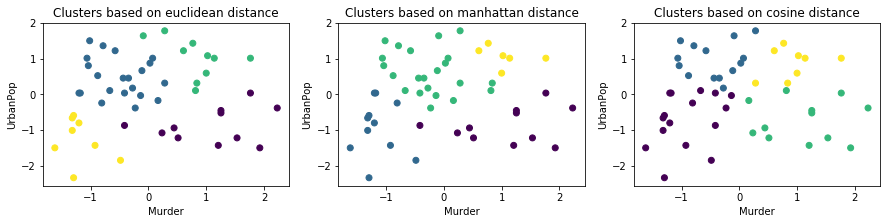

In [19]:
plt.figure(figsize=[15, 3])

distance_types = ['euclidean', 'manhattan', 'cosine']

for i, d in enumerate(distance_types):
    plt.subplot(1, 3, i+1)

    cluster = AgglomerativeClustering(n_clusters=k, affinity=d,
                                      linkage=L)
    cluster.fit_predict(X)

    ax = plt.scatter(X[:, 0], X[:, 1], c=cluster.labels_)

    plt.title('Clusters based on {} distance'.format(d))
    plt.xlabel('Murder')
    plt.ylabel('UrbanPop')


From the graphs above you see the Euclidean distance gave the best result. An honest opinion would be that there is not much distance between the k means cluster. The default of the KMeans cluster is Euclidean and it did have a cluster value of 4. So the only difference was the linkage method. 

The purple data points represent areas with high murder rates but low to medium urban populations. The green high to mid range murder rates with a high urban population. The blue points represent lower murder rates but low to middle urban populations. Last but not least yellow represents areas with low murder rates and low urban populations.

My interpretation is that the purple points are areas that are farming towns with lots of bush and neighbours far away from each other. It's often you would find not just incidental shootings of children by other children but also cults and serial killers. The state of Alabama is a prime example of this.

If you look at the blue dots you see that generally it's a high urban population but on the lower end of the murder scale. Why is this? Because for the most part urban areas are often represented in the news as the most dangerous. Funny thing is if you look at California it is a prime example of this. The reason is that more police are dispatched in these areas. Most residents fear for their life due to the police brutality and murderous tendencies of the LAPD. Laws have been put in place such as the "Gang enhancement law" that adds extra sentencing to convicts if gang affiliation is discovered during trial. Another case is New Jersey, during the 80's New York Governor Rudi Guilianni launched a full scale attack on the mafia which put more mob members behind bars than any other era. Bill Clinton also introduced stop and frisk during the 90's where cops could search anyone they thought was suspicious without any warrant or reasoning.

Basically what I'm trying to lay out here is that the police have cracked down on crime ridden neighbourhoods so much that they've forgotten about farm lands. They don't see the big picture and it will be to their detriment. The presumption of innocence does not hold true if you come from a worse neighbourhood, happen to be an immigrant, black or latino.
